In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Выделение краев алгоритмом Canny:

In [32]:
def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 30, 150)
    return edges

# 2.пороговым методом с глобальным порогом T, реализовать определение порога:

## 2.1 Определение порога на основе площади (P-tile)

In [33]:
def ptile_threshold(image, p):
    flat_image = image.flatten()
    flat_image.sort()
    idx = int(len(flat_image) * p)
    threshold = flat_image[idx]
    return threshold

## 2.2 Пороговый метод с последовательными приближениями

In [79]:
def iterative_threshold(image, initial_threshold=128, max_iterations=100, tolerance=1):
    old_threshold = initial_threshold
    for _ in range(max_iterations):
        below_threshold = image < old_threshold
        above_threshold = image >= old_threshold
        mean_below = np.mean(image[below_threshold])
        mean_above = np.mean(image[above_threshold])
        new_threshold = (mean_below + mean_above) / 2
        # if abs(new_threshold - old_threshold) < tolerance:
        #     break
        old_threshold = new_threshold
    return new_threshold


## 2.3 Метод k-средних

In [35]:
def kmeans_threshold(image, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(image.flatten().astype(np.float32), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    threshold = int(centers[-1][0])
    return threshold

# 3. Пороговый метод с адаптивным порогом

In [36]:
def adaptive_threshold(image, block_size, C):
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, block_size, C)

# 4. Обработка видео

In [37]:
def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        edges = adaptive_threshold(frame)
        cv2.imshow('Edges', edges)
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

video_path = '../assets/sample_640x360.mp4'
process_video(video_path)


TypeError: adaptive_threshold() missing 2 required positional arguments: 'block_size' and 'C'

# Демонстрация работы

68
139.6886945124258
83


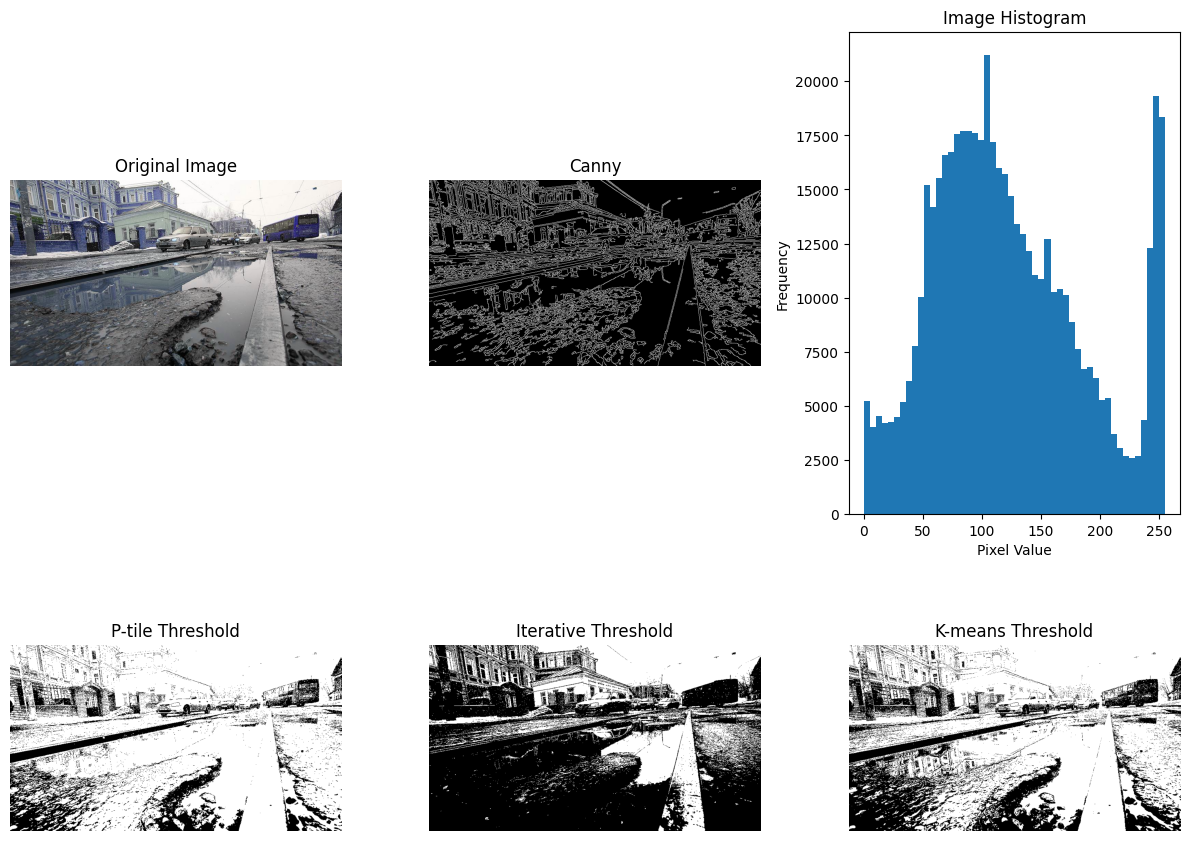

In [91]:
# Загрузка изображения
image_path = '../assets/cars.jpg'
image_color = cv2.imread(image_path)
image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

edges = detect_edges(image_color)

p = 0.2
ptile_thresh = ptile_threshold(image, p)
print(ptile_thresh)

iter_thresh = iterative_threshold(image, initial_threshold=20, max_iterations=1000)
print(iter_thresh)

k = 2
kmeans_thresh = kmeans_threshold(image, k)
print(kmeans_thresh)

block_size = 11
C = 2


plt.figure(figsize=(12, 10))

plt.subplot(2, 3, 1)
plt.imshow(image_color)
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(edges, cmap='gray')
plt.title('Canny')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.hist(image.flatten(), bins=50)
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(2, 3, 4)
plt.imshow(image > ptile_thresh, cmap='gray')
plt.title('P-tile Threshold')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image > iter_thresh, cmap='gray')
plt.title('Iterative Threshold')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image > kmeans_thresh, cmap='gray')
plt.title('K-means Threshold')
plt.axis('off')

plt.tight_layout()
plt.show()
